In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

Note: Data is from https://opendata.dc.gov/ and the dataset from September 2023 is missing
Metadata: https://www.arcgis.com/sharing/rest/content/items/17d73d958f8247e19a4885a4d8bce9dd/info/metadata/metadata.xml?format=default&output=html

In [14]:
def load_parking_violation_data(data_folder):
    files = os.listdir(data_folder)
    print(files)
    all_csvs = glob.glob(os.path.join(data_folder, "*.csv"))
    dfs = []
    for c in all_csvs:
        try:
          df = pd.read_csv(c)
          dfs.append(df)
          print(f"successfully loaded {c}")
        except Exception as e:
          print(f"error opening {c}: {e}")
    return pd.concat(dfs, ignore_index=True)

In [15]:
df = load_parking_violation_data("../Data")

['Parking_Violations_Issued_in_June_2025.csv', 'Parking_Violations_Issued_in_November_2024.csv', 'Parking_Violations_Issued_in_July_2024.csv', '.DS_Store', 'Parking_Violations_Issued_in_January_2025.csv', 'Parking_Violations_Issued_in_October_2024.csv', 'Parking_Violations_Issued_in_March_2025.csv', 'Parking_Violations_Issued_in_December_2024.csv', 'Parking_Violations_Issued_in_April_2025.csv', 'Parking_Violations_Violations_Issued_in_May_2025.csv', 'Parking_Violations_Issued_in_February_2025.csv', 'Parking_Violations_Issued_in_August_2024.csv', 'Parking_Violations_Issued_in_September_2024.csv']
successfully loaded ../Data/Parking_Violations_Issued_in_June_2025.csv
successfully loaded ../Data/Parking_Violations_Issued_in_November_2024.csv
successfully loaded ../Data/Parking_Violations_Issued_in_July_2024.csv
successfully loaded ../Data/Parking_Violations_Issued_in_January_2025.csv
successfully loaded ../Data/Parking_Violations_Issued_in_October_2024.csv
successfully loaded ../Data/Park

/var/folders/5n/jjx2myys12g9lmz1yqf0txth0000gn/T/ipykernel_54846/2234199005.py:8: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(c)


In [16]:
len(df)

1103816

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df.dtypes

OBJECTID                  int64
TICKET_NUMBER             int64
ISSUE_DATE               object
ISSUE_TIME                int64
ISSUING_AGENCY_CODE       int64
ISSUING_AGENCY_NAME      object
ISSUING_AGENCY_SHORT     object
VIOLATION_CODE           object
LOCATION                 object
PLATE_STATE              object
DISPOSITION_CODE          int64
DISPOSITION_TYPE         object
DISPOSITION_DATE         object
FINE_AMOUNT               int64
TOTAL_PAID                int64
PENALTY_1                 int64
PENALTY_2                 int64
PENALTY_3                 int64
PENALTY_4                 int64
PENALTY_5                 int64
XCOORD                  float64
YCOORD                  float64
LATITUDE                float64
LONGITUDE               float64
MAR_ID                  float64
GIS_LAST_MOD_DTTM        object
VIOLATION_PROC_DESC      object
VEHICLE_TYPE            float64
MULTI_OWNER_NUMBER        int64
DISPOSITION_DESC         object
VIOLATION_TYPE_DESC      object
dtype: o

In [19]:
df.isnull().sum()[df.isnull().sum() > 0]

DISPOSITION_DATE       1065200
XCOORD                    9516
YCOORD                    9516
LATITUDE                  9516
LONGITUDE                 9516
MAR_ID                    9516
VIOLATION_PROC_DESC        171
VEHICLE_TYPE           1103816
DISPOSITION_DESC       1065206
VIOLATION_TYPE_DESC     528578
dtype: int64

In [20]:
df['ISSUE_DATE'] = pd.to_datetime(df['ISSUE_DATE'], errors='coerce')
df['ISSUE_DATE'] = df['ISSUE_DATE'].dt.tz_localize(None)

In [21]:
df['parsed_time'] = pd.to_datetime(df['ISSUE_TIME'].astype(str).str.zfill(4), format='%H%M', errors='coerce')
df['hour'] = df['parsed_time'].dt.hour
df['minute'] = df['parsed_time'].dt.minute

In [22]:
df = df[df['ISSUE_DATE'].notna() & df['hour'].notna() & df['minute'].notna()]

In [23]:
df['issue_datetime'] = df['ISSUE_DATE'].dt.floor('D') \
    + pd.to_timedelta(df['hour'], unit='h') \
    + pd.to_timedelta(df['minute'], unit='m')

In [24]:
df.drop(columns=['hour', 'minute', 'ISSUE_DATE', 'ISSUE_TIME', 'parsed_time'], inplace=True)

In [25]:
# Almost all of the data is missing these values, so dropping
df.drop(columns=[
    'VEHICLE_TYPE',
    'DISPOSITION_DESC',
    'DISPOSITION_DATE'], inplace=True)

In [26]:
# New date + time related columns for future use

df['year'] = df['issue_datetime'].dt.year
df['month'] = df['issue_datetime'].dt.month
df['day'] = df['issue_datetime'].dt.day
df['day_of_week'] = df['issue_datetime'].dt.day_name()
df['hour'] = df['issue_datetime'].dt.hour
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

In [27]:
# Filling missing values
df['VIOLATION_PROC_DESC'] = df['VIOLATION_PROC_DESC'].fillna("UNKNOWN")

In [28]:
df[''] = df['VIOLATION_TYPE_DESC'].fillna("UNKNOWN")

In [29]:
df.drop(columns=['XCOORD', 'YCOORD', 'MAR_ID'], inplace=True)

In [30]:
df['MULTI_OWNER_NUMBER'].value_counts(dropna=False)

MULTI_OWNER_NUMBER
0            1046009
20714000        4023
20719000         678
10629000         478
20811000         468
              ...   
950625415          1
950721667          1
950569011          1
950646151          1
950713479          1
Name: count, Length: 18247, dtype: int64

In [31]:
# from the metadata - "If number exists, this is referring to either a fleet, government, or rental vehicle." so probably more valuable to represent as a boolean
df['is_fleet_gov_or_rental'] = df['MULTI_OWNER_NUMBER'].notna()
df.drop(columns=['MULTI_OWNER_NUMBER'], inplace=True)

In [32]:
# care about location in DC, so drop violations with null latitude and longitude
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

In [33]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'nulls': df.isnull().sum(),
    'unique_vals': df.nunique()
})
summary

,dtype,nulls,unique_vals
OBJECTID,int64,0,1094297
TICKET_NUMBER,int64,0,1094297
ISSUING_AGENCY_CODE,int64,0,40
ISSUING_AGENCY_NAME,object,0,40
ISSUING_AGENCY_SHORT,object,0,40
VIOLATION_CODE,object,0,217
LOCATION,object,0,49415
PLATE_STATE,object,0,42
DISPOSITION_CODE,int64,0,54
DISPOSITION_TYPE,object,0,7


### Initial Visualization

<Axes: xlabel='issue_datetime'>

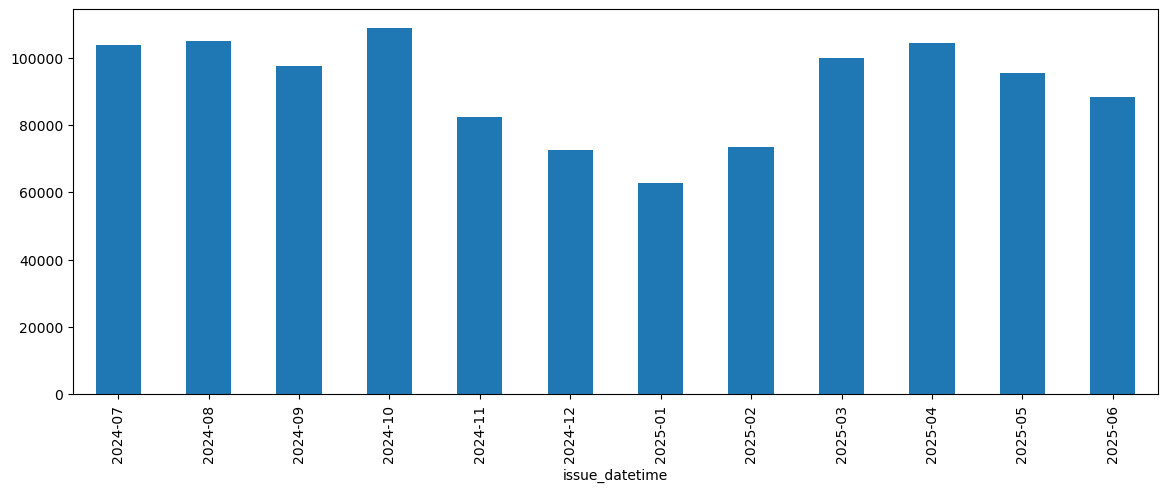

In [34]:
df.groupby(df['issue_datetime'].dt.to_period('M')).size().plot(kind='bar', figsize=(14,5))

<Axes: xlabel='day_of_week', ylabel='count'>

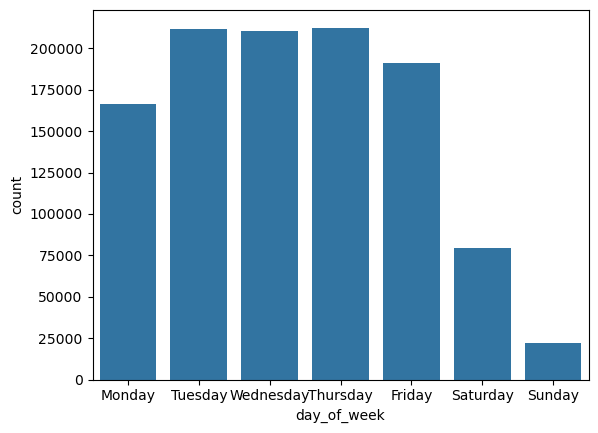

In [35]:
sns.countplot(data=df, x='day_of_week', order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

<Axes: xlabel='hour', ylabel='Count'>

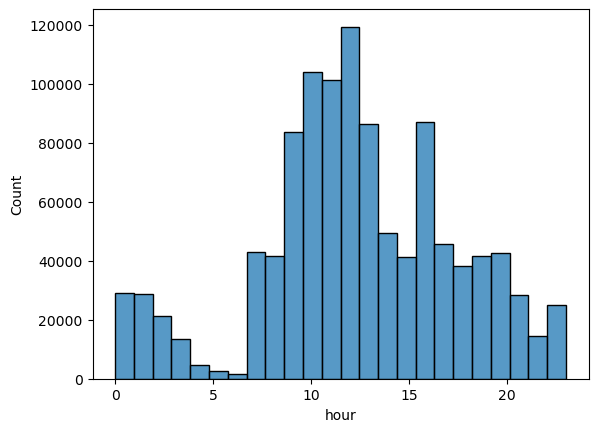

In [36]:
sns.histplot(df['hour'], bins=24, kde=False)

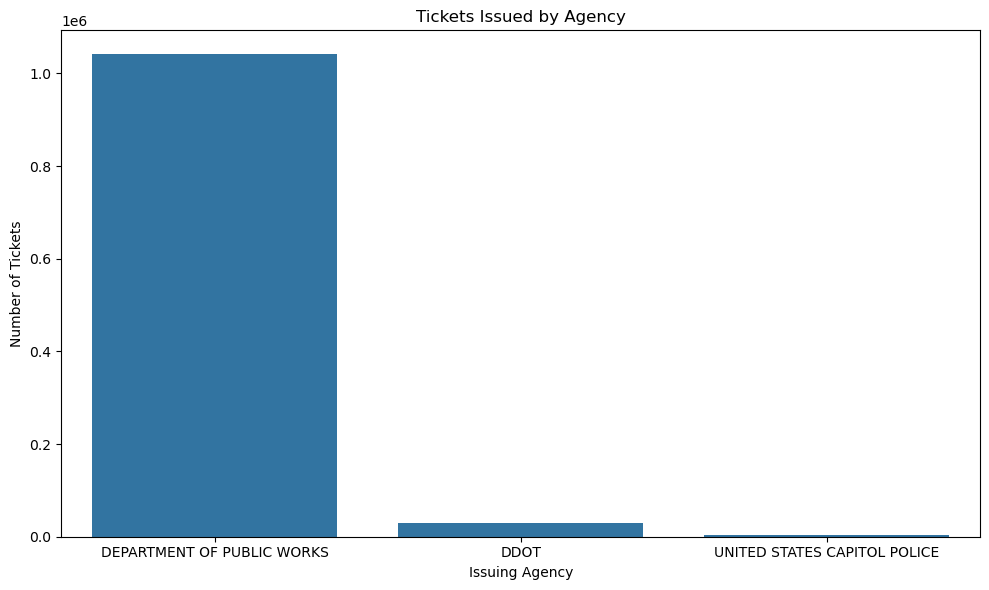

In [38]:
agency_counts = df['ISSUING_AGENCY_NAME'].value_counts()
top_agencies = agency_counts.head(3)

plt.figure(figsize=(10,6))
sns.barplot(x=top_agencies.index, y=top_agencies.values)

plt.title("Tickets Issued by Agency")
plt.xlabel("Issuing Agency")
plt.ylabel("Number of Tickets")
plt.tight_layout()
plt.show()

In [39]:
df.columns = df.columns.str.lower()

In [40]:
df.head()

,objectid,ticket_number,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,location,plate_state,disposition_code,disposition_type,...,violation_type_desc,issue_datetime,year,month,day,day_of_week,hour,is_weekend,,is_fleet_gov_or_rental
30,84395696,275257905,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P055,SIDE 1201 CONSTITUTION AVE NW,,134,Dismissed,...,NaN,2025-06-17 12:28:00,2025,6,17,Tuesday,12,False,UNKNOWN,True
32,84395698,275697181,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,0,Other,...,NaN,2025-06-20 23:38:00,2025,6,20,Friday,23,False,UNKNOWN,True
33,84395699,275697203,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,0,Other,...,NaN,2025-06-20 23:54:00,2025,6,20,Friday,23,False,UNKNOWN,True
34,84395717,276503242,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P269,NS 600 BLK MARYLAND AVE SW,,0,Other,...,NaN,2025-06-04 07:45:00,2025,6,4,Wednesday,7,False,UNKNOWN,True
35,84395718,276503253,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P168,NS 600 BLK MARYLAND AVE SW,,0,Other,...,NaN,2025-06-04 07:45:00,2025,6,4,Wednesday,7,False,UNKNOWN,True


In [41]:
df[df['issue_datetime'].isna()]

,objectid,ticket_number,issuing_agency_code,issuing_agency_name,issuing_agency_short,violation_code,location,plate_state,disposition_code,disposition_type,...,violation_type_desc,issue_datetime,year,month,day,day_of_week,hour,is_weekend,,is_fleet_gov_or_rental


In [44]:
df.to_csv('../CleanData/cleaned_parking_violations_v2.csv', index=False)